<a href="https://colab.research.google.com/github/jads-nl/execute-nhs-proms/blob/master/notebooks/1.0-data-understanding.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background to osteoarthritis case study

_taken from [narrative seminar Osteoarthritis by Hunter & Bierma-Zeinstra (2019) in the Lancet](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/hunter2019osteaoarthritis.pdf)._

Hip and knee osteoarthritis is a leading cause of disability and source of societal cost in older adults. Global prevalence of osteoarthritis is increasing and the burden of the disease will rise. The medical cost of osteoarthritis in various high-income countries has been estimated to account for between 1% and 2.5% of the gross domestic product of these countries, with hip and knee joint replacements representing the major proportion of these healthcare costs.

Joint replacement surgery is a clinically relevant and cost-effective treatment for end-stage osteoarthritis. The characteristics of end-stage osteoarthritis include joint pain, which disrupts normal sleep patterns and causes a severe reduction in capable walking distance and marked restriction of daily activities. Hence, the aim of knee and hip replacements is to alleviate pain and disability in daily functioning.

However, up to 25% of patients presenting for total joint replacement continue to complain of pain and disability 1 year after well performed surgery. With data available on thousands of patients, the question arises to what extent it is possible to predict treatment success. This could be useful in supporting doctors in deciding whether knee replacement is indicated, and could help give patients a more personalised assessment of what to expect of treatment.

# CRISP-DM phase 1 and 2: Business and Data Understanding

This notebook is an adaptation from the more extensive material found in the [5-day JADS NHS PROMs data science case study](https://github.com/dkapitan/jads-nhs-proms/blob/master/README.md).

## Learning objectives

- get familiar with the look and feel of Python
- get familiar with Google Colab
- see how business and data understanding are intimately connected
- see how business and data understanding come about iteratively
- get an overview of the aspects to consider in both of these CRISP-DM phases
- get a sense of the type of work the data scientist would be doing and the type of questions to ask the data scientist in these stages

#### Business Understanding
- Determine objectives
- Assess the current situation
- Determine data mining and machine learning goals


#### Data Understanding
- Define the outcome Y
- Explore the outcome Y
- Describe features
- Assess data quality
- Determine usability of features
- Explore relations in the data
- Assess completeness of the data

## Business Understanding
Assume that the primary reasons to replace a knee are to **i) reduce pain**, and **ii) improve daily functioning**. The dataset contains the various patient-reported outcome measures that can be used to measure the outcome along the following two dimenions:
- Oxford Knee Score (OKS): a 12-item questionnaire that assess pain as well as daily functioning c.q. disability due to knee osteoarthritis:   
  - Items are scored from [0,4], where higher scores indicate better outcomes (less disability).
  - The questionnaire contains two separate questions on pain and night pain, again on a [0,4] scale.
- EQ-5D: generic quality of life PROMs along 5 dimensions on a 3-point Likert scale [1,3], where lower scores indicate better outcomes. Dimensions are activity, anxiety, discomfort, mobility and self-care.
- EQ-VAS: general reported health on a scale from [0,100], where higher scores indicate better outcomes.

We will explore the PROMs data to gather input on how to define the outcome Y, such that it meaningfully assesses the outcome of knee replacement. Note that PROMs are measured at T0 (prior to surgery) and T1 (six months after surgery).
- [NHS PROMs methodology](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/nhs/proms_guide_v12.pdf)
- [NHS PROMs data dictionary](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/nhs/proms_data_dictionary.pdf)

## Data Understanding


#### To gather input for business understanding

This is where the code starts; we first go through some 'formalities', where we import the libraries that will be used in the notebook, and define how output should be displayed in this notebook to make results more readible.

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, VarianceThreshold
import sklearn.linear_model

# supressing warnings for readability
warnings.filterwarnings("ignore")

# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use("seaborn-whitegrid")

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc("axes", labelsize=14, titlesize=14)
mpl.rc("figure", titlesize=20)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# contants for figsize
S = (8, 8)
M = (12, 12)
L = (14, 14)

# if you have wide tables, adjust these settings to enable scrolling
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

Now we are ready to import the data and assign the data to the object with the name df ('dataframe') 

In [2]:
# import data
df = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

#### A quick glance at the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139236 entries, 0 to 139235
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   provider_code                 139236 non-null  category
 1   procedure                     139236 non-null  category
 2   revision_flag                 139236 non-null  uint8   
 3   year                          139236 non-null  category
 4   age_band                      129834 non-null  category
 5   gender                        129834 non-null  float32 
 6   t0_assisted                   139236 non-null  uint8   
 7   t0_assisted_by                139236 non-null  uint8   
 8   t0_symptom_period             139236 non-null  uint8   
 9   t0_previous_surgery           139236 non-null  uint8   
 10  t0_living_arrangements        139236 non-null  uint8   
 11  t0_disability                 139236 non-null  uint8   
 12  heart_disease                 

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revision_flag,139236.0,0.04,0.19,0.00,0.00,0.00,0.00,1.00
gender,129834.0,1.57,0.49,1.00,1.00,2.00,2.00,2.00
t0_assisted,139236.0,1.92,0.82,1.00,2.00,2.00,2.00,9.00
t0_assisted_by,139236.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
t0_symptom_period,139236.0,2.65,1.05,1.00,2.00,2.00,3.00,9.00
t0_previous_surgery,139236.0,1.97,0.67,1.00,2.00,2.00,2.00,9.00
t0_living_arrangements,139236.0,1.35,1.04,1.00,1.00,1.00,1.00,9.00
t0_disability,139236.0,1.81,1.59,1.00,1.00,2.00,2.00,9.00
heart_disease,139236.0,8.25,2.33,1.00,9.00,9.00,9.00,9.00
high_bp,139236.0,5.46,3.97,1.00,1.00,9.00,9.00,9.00


### Explore possible outcomes Y

In [5]:
proms = ['oks_t0_score', 'oks_t1_score', 'oks_t0_pain', 'oks_t1_pain', 'oks_t0_night_pain', 'oks_t1_night_pain', 't0_discomfort', 't1_discomfort', 't0_eq_vas', 't1_eq_vas', ]
df.loc[:,proms].describe().transpose().round(1)

,count,mean,std,min,25%,50%,75%,max
oks_t0_score,137567.0,19.0,7.7,0.0,13.0,19.0,24.0,48.0
oks_t1_score,136657.0,35.9,9.5,0.0,30.0,38.0,43.0,48.0
oks_t0_pain,139236.0,0.6,0.7,0.0,0.0,0.0,1.0,9.0
oks_t1_pain,139236.0,2.7,1.3,0.0,2.0,3.0,4.0,9.0
oks_t0_night_pain,139236.0,1.3,1.4,0.0,0.0,1.0,2.0,9.0
oks_t1_night_pain,139236.0,2.9,1.3,0.0,2.0,3.0,4.0,9.0
t0_discomfort,139236.0,2.6,1.4,1.0,2.0,2.0,3.0,9.0
t1_discomfort,139236.0,1.9,1.3,1.0,1.0,2.0,2.0,9.0
t0_eq_vas,139236.0,154.0,271.4,0.0,55.0,75.0,89.0,999.0
t1_eq_vas,139236.0,118.2,196.4,0.0,69.0,80.0,90.0,999.0


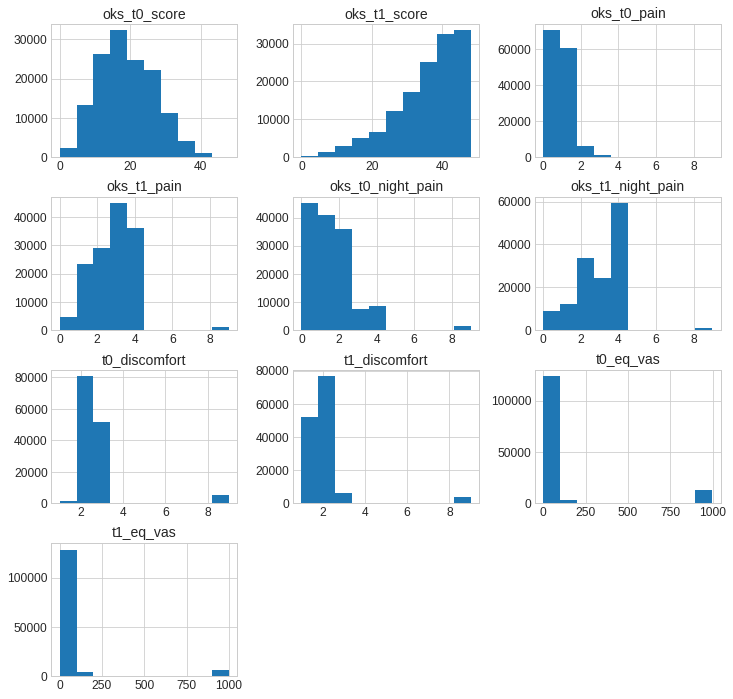

In [6]:
# inspect with histograms
df.loc[:,proms].hist(figsize=M);

### Missing values and sentinel values
The histograms shown earlier indicate [sentinel values](https://en.wikipedia.org/wiki/Sentinel_value) are used to encode missing values:
* `9` for individual OKS questions
* `999` for EQ VAS

In [7]:
df.loc[:,['t0_eq_vas', 't1_eq_vas']].apply(pd.value_counts).tail()

,t0_eq_vas,t1_eq_vas
97,391,882
98,444,1015
99,332,618
100,2707,4261
999,12961,6546


In [8]:
_no9 = [col for col in df.columns if col.startswith('oks_t') and not col.endswith('score')]
df.loc[:,_no9].apply(pd.value_counts)

,oks_t0_pain,oks_t0_night_pain,oks_t0_washing,oks_t0_transport,oks_t0_walking,oks_t0_standing,oks_t0_limping,oks_t0_kneeling,oks_t0_work,oks_t0_confidence,oks_t0_shopping,oks_t0_stairs,oks_t1_pain,oks_t1_night_pain,oks_t1_washing,oks_t1_transport,oks_t1_walking,oks_t1_standing,oks_t1_limping,oks_t1_kneeling,oks_t1_work,oks_t1_confidence,oks_t1_shopping,oks_t1_stairs
0,70493,45021,810,740,17037,4765,60433,60103,18286,18877,24162,7612,4638,8955,356,360,3963,501,6235,42702,2484,1707,9043,3232
1,60701,40943,12189,31896,17499,59989,47425,48650,59140,40686,27235,46072,23471,12180,2283,5909,5110,7965,10319,23453,8443,4511,6134,8740
2,6171,35851,43630,72115,56402,50796,16080,24326,47021,32501,46012,58010,28987,33555,12700,32345,14790,23588,10525,30319,25129,7807,16628,26724
3,1340,7380,38234,23997,35763,19684,12158,4022,11494,35050,26975,21349,44799,24498,25157,46526,30372,53884,50910,30361,45873,34264,27699,42941
4,333,8737,44248,9138,11092,2549,1725,739,1939,10780,13509,4855,36051,59171,97502,52859,83740,52292,60150,11310,56295,90000,78727,56619
9,198,1304,125,1350,1443,1453,1415,1396,1356,1342,1343,1338,1290,877,1238,1237,1261,1006,1097,1091,1012,947,1005,980


### Handling missing values

#### **Question:** what are relevant considerations to handle NAs?
- imputation with mean/median?
- just drop all?

We need to handle the missing data one way or another, in order to better be able to further explore our outcome Y. For now we choose to replace the sentinal values by missings and then drop these missing values. In a next iteration we will look into more sophisticated methods for imputing missing data.

In [9]:
# we work with a copy of our original database, such that we do not overwrite the original data
dfc = df.copy()
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']] = dfc.loc[:,['t0_eq_vas', 't1_eq_vas']].replace(999, np.nan).astype('Int64')
dfc.loc[:,['t0_eq_vas', 't1_eq_vas']].head()

,t0_eq_vas,t1_eq_vas
0,80,<NA>
1,<NA>,95
2,<NA>,98
3,<NA>,60
4,75,80


In [10]:
# compared to the original data
df.loc[:,['t0_eq_vas', 't1_eq_vas']].head()

,t0_eq_vas,t1_eq_vas
0,80,999
1,999,95
2,999,98
3,999,60
4,75,80


In [11]:
# simarly, we change 9 to N/A for the OKS variables and compare the number 
# of missings in the original data (df) and in the copy (dfc) 
dfc.loc[:,_no9] = df.loc[:,_no9].replace(9, np.nan).astype('Int64')
pd.concat([df.loc[:,_no9].isnull().sum(), dfc.loc[:,_no9].isnull().sum()], axis=1, keys=['df', 'dfc'])

,df,dfc
oks_t0_pain,0,198
oks_t0_night_pain,0,1304
oks_t0_washing,0,125
oks_t0_transport,0,1350
oks_t0_walking,0,1443
oks_t0_standing,0,1453
oks_t0_limping,0,1415
oks_t0_kneeling,0,1396
oks_t0_work,0,1356
oks_t0_confidence,0,1342


#### Dropping `NA`s

Now we drop all the missings in the copied dataset dfc, such that we end up with only those rows where there are no missings

In [12]:
dfc.dropna(inplace=True)
print(df.shape)
print(dfc.shape)

(139236, 81)
(103486, 81)


### Explore possible outcomes Y (continued)

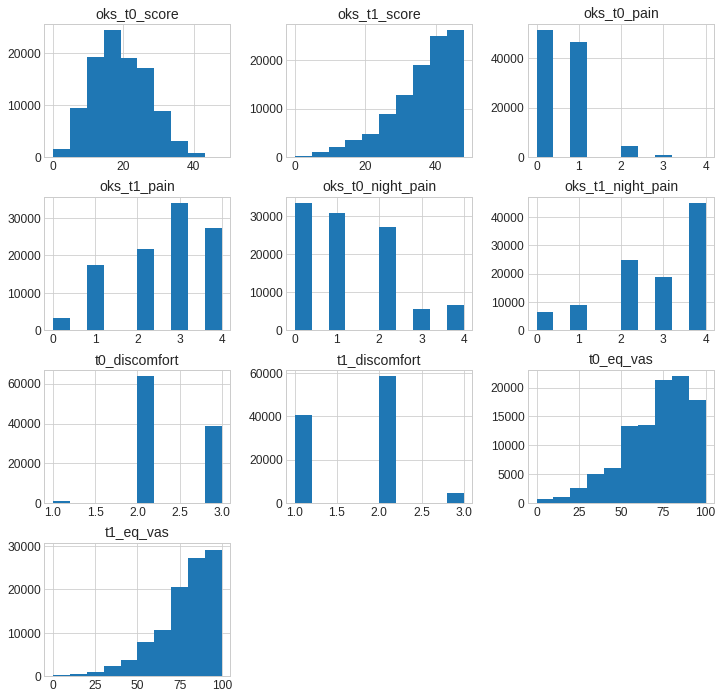

In [13]:
# inspect with histograms
dfc.loc[:,proms].hist(figsize=M);

Take a moment to think about the many possibilities to define the outcome:
- reaching a score below a disability threshold on the OKS
- reaching a score below a pain threshold on the OKS
- reaching a minimum quality of life score on the EQ-5D or EQ-VAS 
- reaching a minimum improvement (absolute or relative) as compared to the scores before replacement
- any combination of the above criteria

The data will not tell you which definition is 'best'. The data could tell you, however, whether certain options are likely to be bad choices (due to lack of variation, or other undesired features resulting from the choice of definition)

For now, let's assume that clinical experts tell us to focus our predictive modeling efforts towards modeling the change in overall OKS-scores, given the variance between the pre- and postoperative values:

$${\Delta} {OKS} = OKS_{T1} - OKS_{T0}$$

This variable is not literally in the data, and therefore needs to be defined first.

#### Y = Improvement in Oxford Knee Score





In [14]:
# define the change in OKS
dfc['delta_oks_score'] = dfc.oks_t1_score - dfc.oks_t0_score

In [15]:
dfc.columns

Index(['provider_code', 'procedure', 'revision_flag', 'year', 'age_band',
       'gender', 't0_assisted', 't0_assisted_by', 't0_symptom_period',
       't0_previous_surgery', 't0_living_arrangements', 't0_disability',
       'heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease',
       'diabetes', 'kidney_disease', 'nervous_system', 'liver_disease',
       'cancer', 'depression', 'arthritis', 't0_mobility', 't0_self_care',
       't0_activity', 't0_discomfort', 't0_anxiety', 't0_eq5d_index_profile',
       't0_eq5d_index', 't1_assisted', 't1_assisted_by',
       't1_living_arrangements', 't1_disability', 't1_mobility',
       't1_self_care', 't1_activity', 't1_discomfort', 't1_anxiety',
       't1_satisfaction', 't1_sucess', 't1_allergy', 't1_bleeding', 't1_wound',
       't1_urine', 't1_further_surgery', 't1_readmitted',
       't1_eq5d_index_profile', 't1_eq5d_index',
       'oks_eq_5d_index_t1_predicted', 't0_eq_vas', 't1_eq_vas',
       'oks_eq_vas_t1_predicted', 'oks

### Exploring Y

#### Distribution and Descriptives

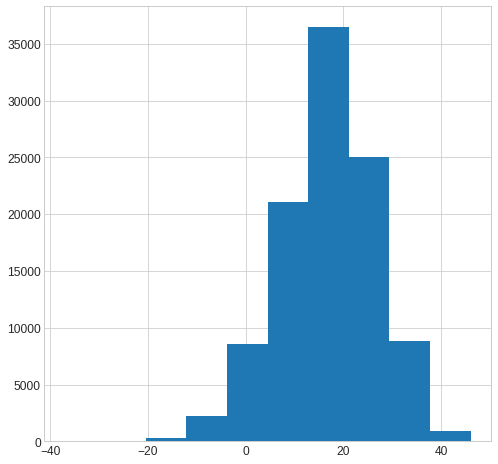

In [16]:
# inspect distribution of the outcome Y with a histogram
dfc.loc[:,'delta_oks_score'].hist(figsize=S);

In [17]:
# describe the change in OKS numerically
dfc.loc[:,'delta_oks_score'].describe()

count    103486.00
mean         16.96
std           9.76
min         -37.00
25%          11.00
50%          17.00
75%          24.00
max          46.00
Name: delta_oks_score, dtype: float64

#### Y by age

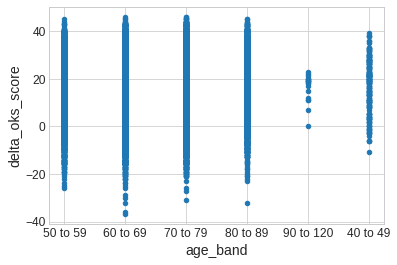

In [18]:
# relation between age and change in OKS
dfc.plot(kind='scatter', x='age_band', y='delta_oks_score');

In [19]:
dfc[dfc.age_band=='90 to 120'].shape

(19, 82)

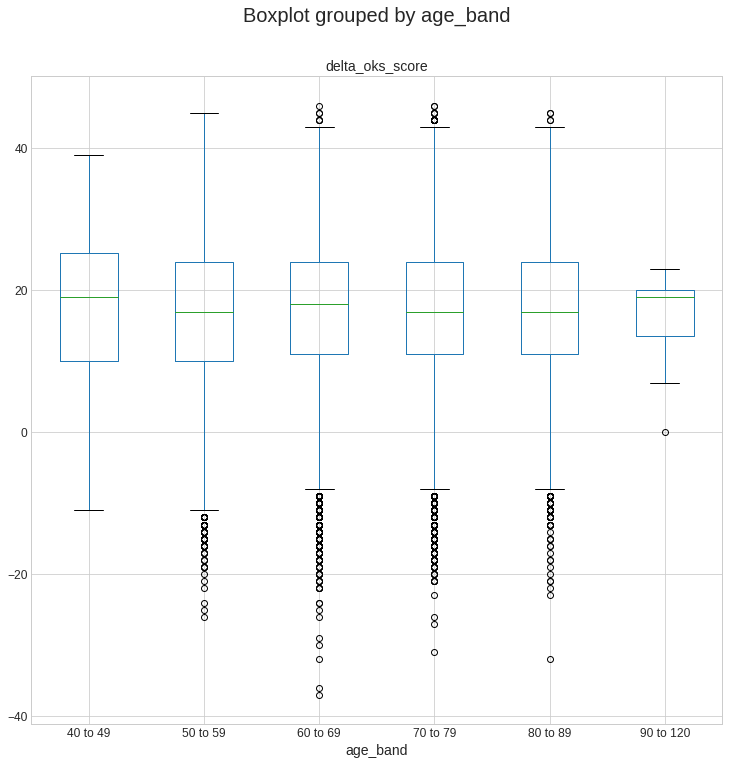

In [20]:
dfc.boxplot(by='age_band', column='delta_oks_score', figsize=M);

#### Y by provider, year

In [21]:
# count number of providers
dfc.provider_code.unique().shape


(276,)

In [22]:
# volume per provider per year (for 10 providers)
volume_provider_year = dfc.groupby(['year', 'provider_code'])['procedure'].count().unstack()
volume_provider_year.iloc[:,0:10]

provider_code,ADP02,AHH,AVQ,NFH01,NN401,NN801,NQM01,NT202,NT204,NT205
year,,,,,,,,,,
2016/17,118,5,0,0,0,14,0,6,32,0
2017/18,183,18,0,0,0,19,0,10,38,0
2018/19,254,0,102,0,6,43,0,12,73,0


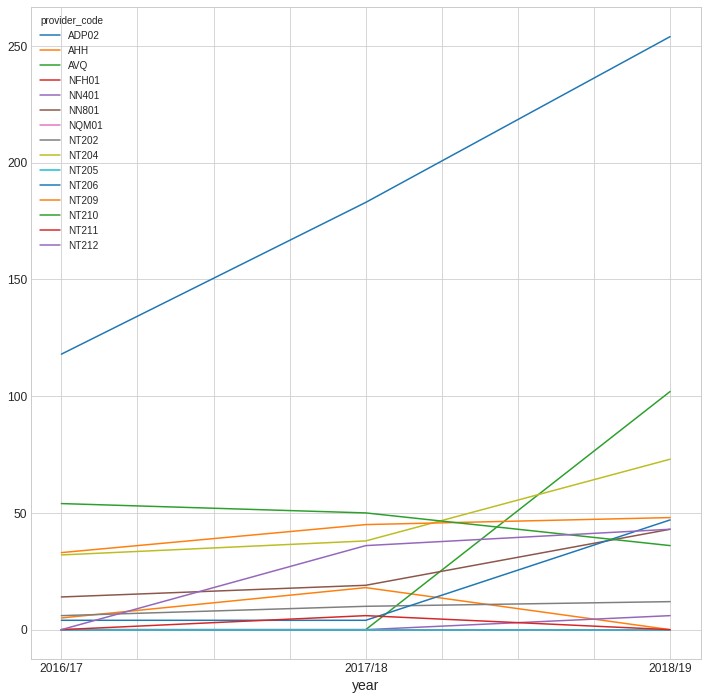

In [23]:
# first 15 providers in the data
volume_provider_year.iloc[:,0:15].plot(figsize=M);

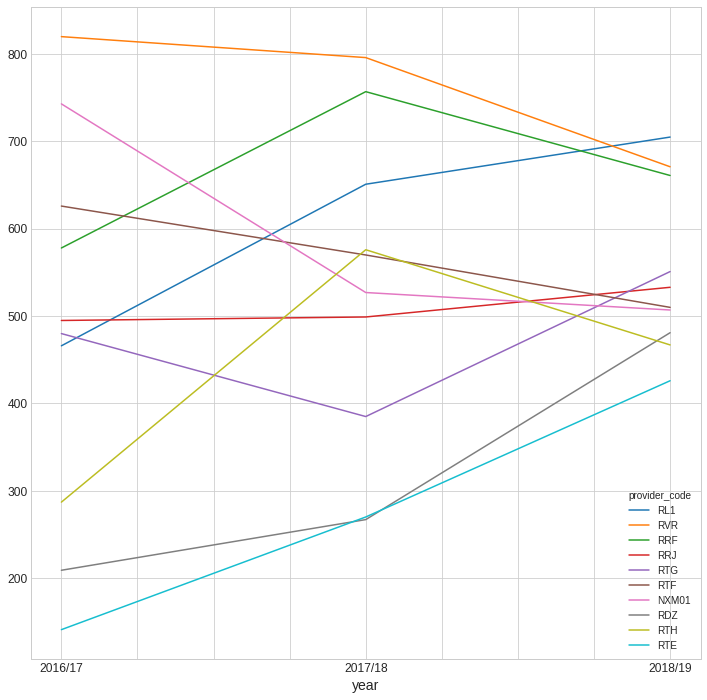

In [24]:
# select 10 largest providers by 2018/19
_year = (df.year == '2018/19')
top10 = df.loc[_year,:].groupby('provider_code').count()['procedure'].sort_values(ascending=False).head(10)
volume_provider_year.loc[:, list(top10.index)].plot(figsize=M);

In [25]:
# calculate descriptive stats for delta_oks per year per provider
dfc.groupby(['year', 'provider_code'])['delta_oks_score'].describe().head()

count   mean    std   min    25%   50%    75%   max
year    provider_code                                                     
2016/17 ADP02          118.0  16.87   9.38 -10.0  12.00  17.0  23.00  37.0
        AHH              5.0  19.60  12.18   0.0  17.00  24.0  25.00  32.0
        NN801           14.0  11.14   7.01  -5.0   9.00  10.0  16.75  22.0
        NT202            6.0  14.67   6.68   4.0  11.75  15.0  19.75  22.0
        NT204           32.0  17.66  10.54  -2.0   9.75  16.0  25.75  36.0

Now we visualize the distributions of the outcome Y for each of the 10 largest providers, in the most recent year in the data

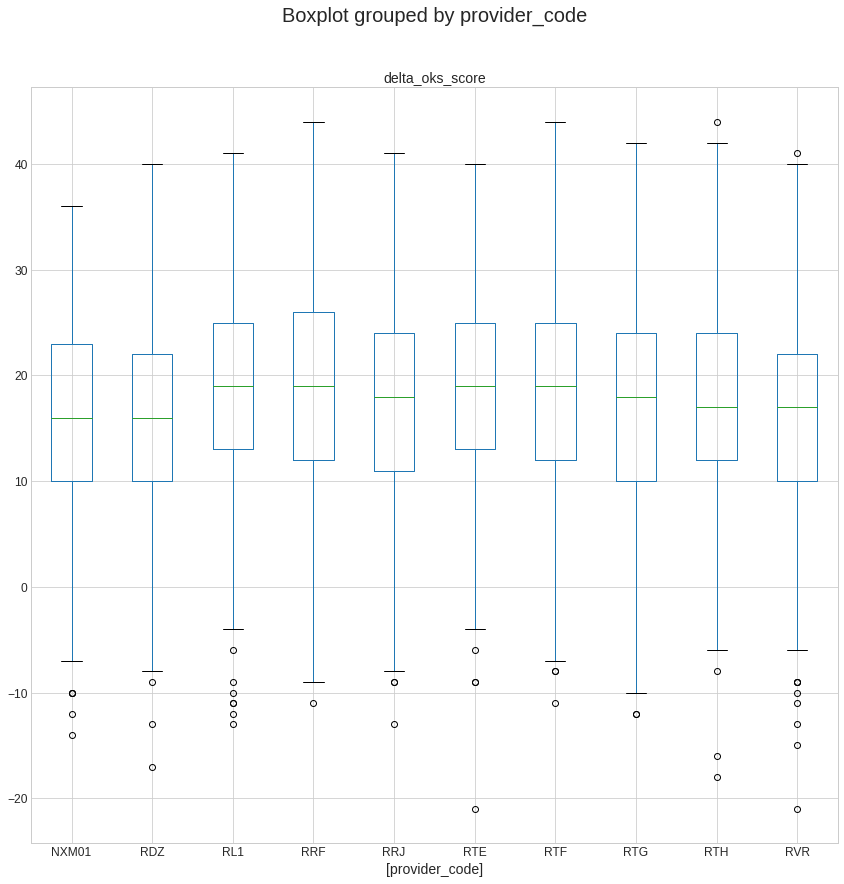

In [26]:
dfc.provider_code = dfc.provider_code.astype('str') # to make sure only the relevant labels are shown in the graph
_top10_latest = (dfc.provider_code.isin(top10.index)) & (dfc.year=='2018/19')
dfc.loc[_top10_latest,['provider_code', 'delta_oks_score']].boxplot(by=['provider_code'], figsize=L);

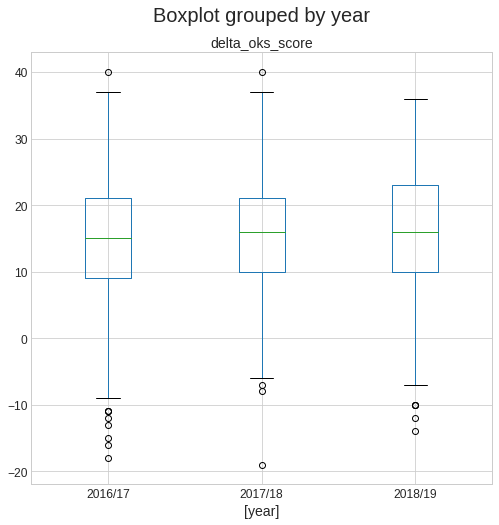

In [27]:
# lets look at a single provider and see whether delta_oks_score changes year-on-year
dfc.loc[(dfc.provider_code.isin(['NXM01'])),['year', 'delta_oks_score']].boxplot(by=['year'], figsize=S);

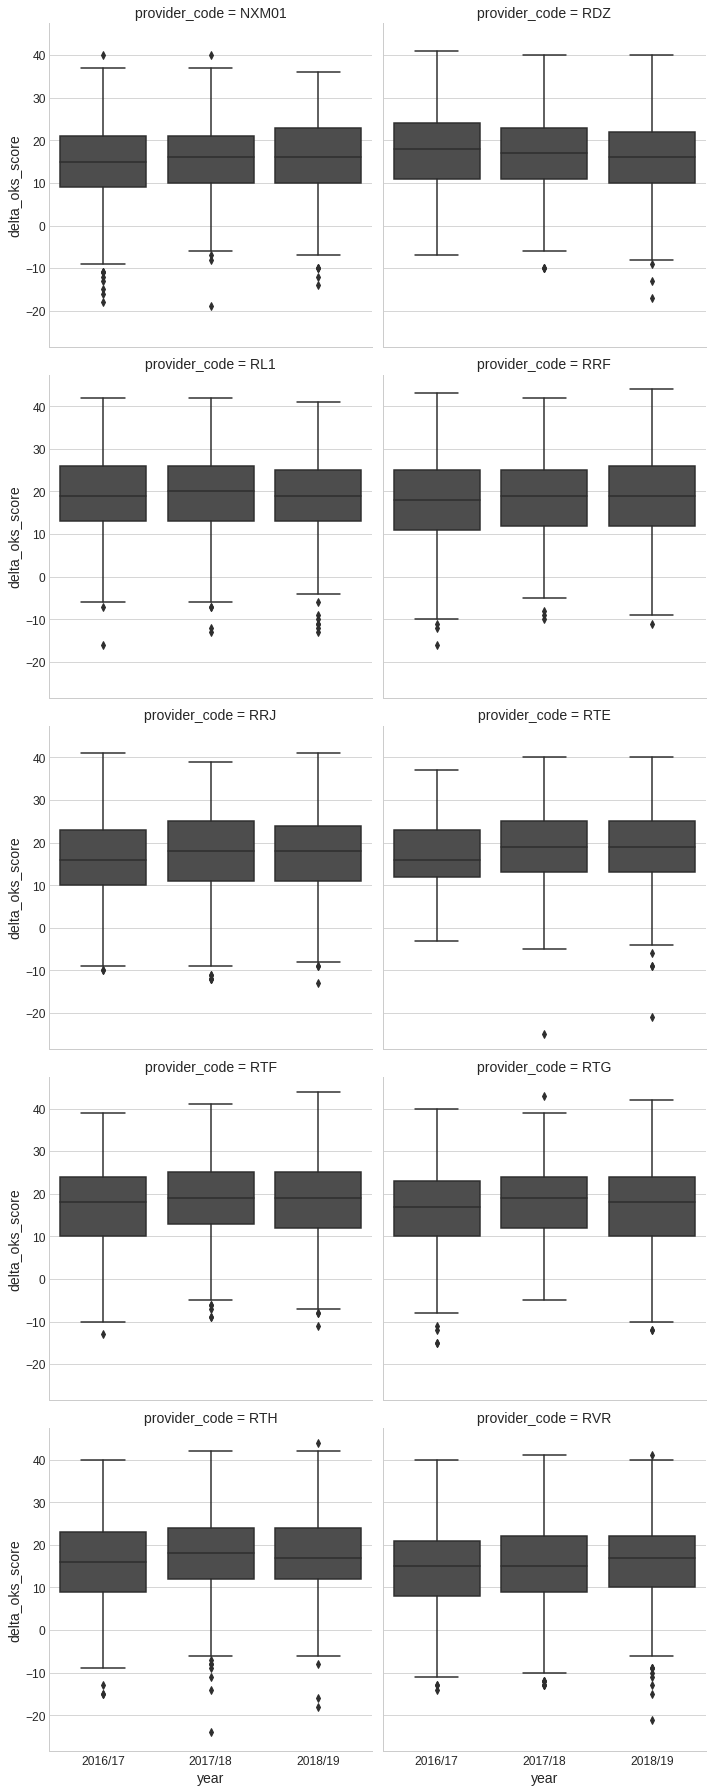

In [28]:
# Now we do the same for each of the providers in the top 10
import seaborn as sns

g = sns.FacetGrid(
    dfc.loc[dfc.provider_code.isin(top10.index), :],
    col="provider_code",
    col_wrap=2,
    height=5,
    gridspec_kws={"figsize": L},
)
g.map(sns.boxplot, "year", "delta_oks_score", color=".3");

#### Y by provider size
Assess whether the outcome Y has a correlation with size of provider?

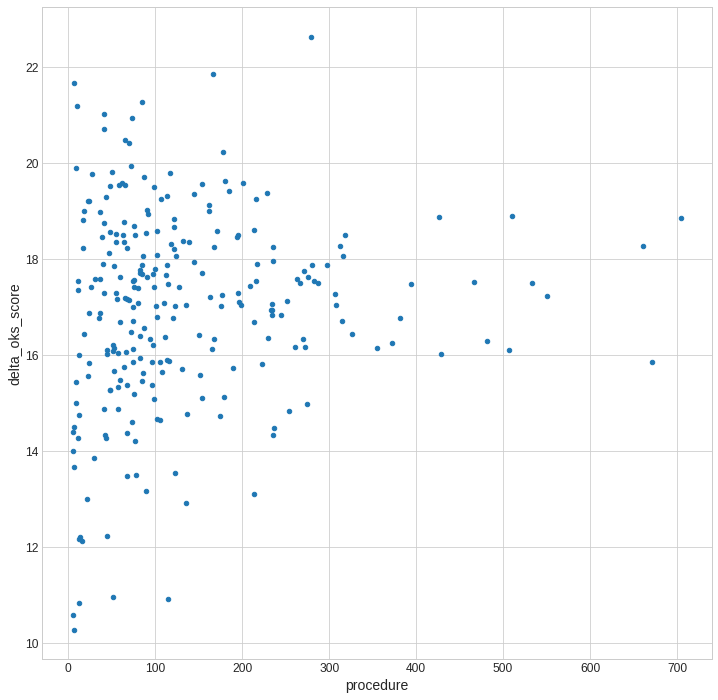

In [29]:
# group by providers for 2018/19
_provider2019 = dfc.loc[(dfc.year == '2018/19'),:].groupby('provider_code')

# count procedures, calculate mean delta_oks_score and plot
(pd.concat([_provider2019.count()['procedure'].sort_values(ascending=False),
          _provider2019.mean()['delta_oks_score']], axis=1)
   .plot(kind='scatter', x='procedure', y='delta_oks_score', figsize=M)
);

#### Discussion

#### **Question:** what other aspects of the data would you be interested in?


### Reconsidering Y

#### Discussion

#### **Question:** reconsider our choice of Y
- Is delta_oks_score adequately capturing treatment success?
- What are possible limitations?
- What alternatives would compensate for those limitations?

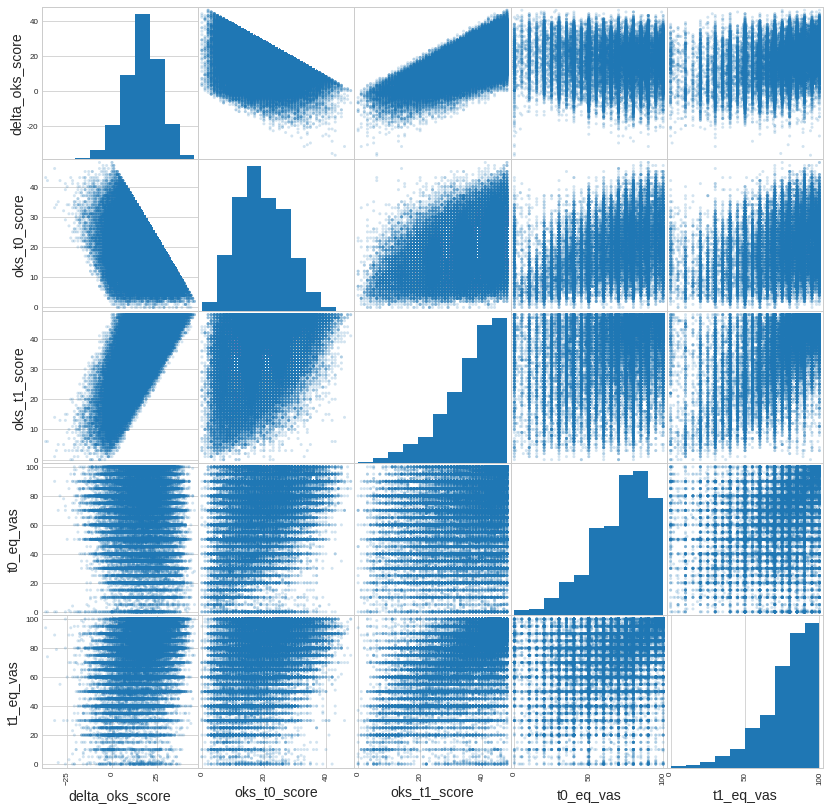

In [30]:
# 3-point scales don't look that interesting, so let's zoom in on oks_score and eq_vas
# note some functions don't work with nullable integer Int64 (yet), so converting back to int64
oks_vas = ['delta_oks_score', 'oks_t0_score', 'oks_t1_score', 't0_eq_vas', 't1_eq_vas']
pd.plotting.scatter_matrix(dfc.loc[:,oks_vas].astype('int64'), figsize=L, alpha=0.2);

#### Ceiling effect
Clearly we need to do something to account for the ceiling effect. So in our second iteration we define a binary outcome parameter Y as 'good' when either `delta_oks_score` is above a certain threshold or `oks_t1_score` is above a certain absolute value.

In [31]:
def good_outcome(oks_t1, delta_oks):
  if oks_t1 > 43 or delta_oks > 13:
    return True
  else:
    return False

dfc['Y'] = dfc.apply(lambda row: good_outcome(row['oks_t1_score'], row['delta_oks_score']), axis=1)

In [37]:
# Is the problem is big as we thought it was?
print(dfc['Y'].value_counts())
print("")
print(dfc['Y'].value_counts(normalize=True))


True     70266
False    33220
Name: Y, dtype: int64

True     0.68
False    0.32
Name: Y, dtype: float64


### Compare Y by casemix variables (using Chi Square test)
Usually casemix attributes are strong predictors for outcomes. With chi-squared test we can assess which categorical variables have strong associations. Note that the casemix indicators are encoded with 1 (present) or 9 (missing).

Note that chi2 requires X and Y to be categorical. Research has shown that an improvement in OKS score of approx. 30% is relevant ([van der Wees 2017](https://github.com/dkapitan/jads-nhs-proms/blob/master/references/vanderwees2017patient-reported.pdf)). Hence an increase of +14 points is considered a 'good' outcome.

In [38]:
casemix = ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes',
           'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis']
dfc.loc[:,casemix] = dfc.loc[:,casemix].replace(1, True).replace(9, False)
chi2_, pval = chi2(dfc.loc[:,casemix], dfc.Y)
chi = pd.DataFrame({'feature': casemix, 'chi2': chi2_, 'p': pval}).sort_values('chi2', ascending=False)
chi

,feature,chi2,p
3,circulation,311.24,1.17e-69
10,depression,194.76,2.91e-44
5,diabetes,144.67,2.54e-33
0,heart_disease,52.72,3.84e-13
2,stroke,21.59,3.37e-06
4,lung_disease,21.08,4.42e-06
6,kidney_disease,14.03,1.80e-04
8,liver_disease,9.50,2.05e-03
7,nervous_system,4.95,2.61e-02
1,high_bp,2.11,1.47e-01


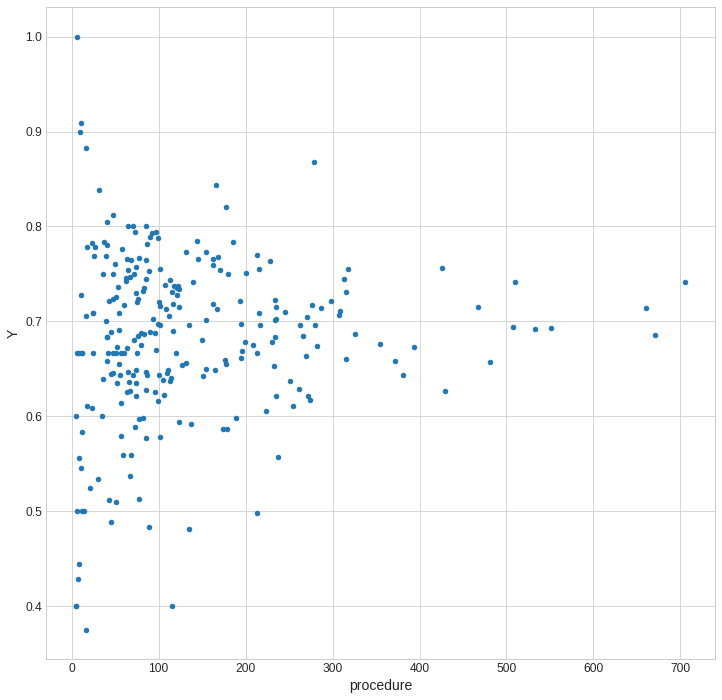

In [39]:
# same approach, using binary Y
# group by providers for 2018/19
_provider2019 = dfc.loc[(dfc.year == '2018/19'),:].groupby('provider_code')


(pd.concat([_provider2019.count()['procedure'].sort_values(ascending=False),
          _provider2019.mean()['Y']], axis=1)
   .plot(kind='scatter', x='procedure', y='Y', figsize=M)
);

# Conclusion and reflection

## Learning objectives

- get familiar with the look and feel of Python
- get familiar with Google Colab
- see how business and data understanding are intimately connected
- see how business and data understanding come about iteratively
- get an overview of the aspects to consider in both of these CRISP-DM phases
- get a sense of the type of work the data scientist would be doing and the type of questions to ask the data scientist in these stages

## Discussion of results

A number of issues arised in this first iteration:
* There is no clear outcome in the data and we have many choices on how to define this outcome
* Not a lot of data is available for the higher age brackets
* Some issues were found regarding the quality of the data
* And more general (reasoning from domain knowledge): do we feel that this dataset contains the features that are needed to predict our outcome?


## Other things to look into

This was only the start of the data understanding phase. There are many other thinks you could look into at this point, such as:
* Listing the variables that are known / not known at the point of prediction
* Listing to what extent all relevant domains of the life of a patient are covered in the data (e.g. work, health, family, lifestyle, therapy)
* Do infeasible combinations of variable values occur in the data (e.g. minors with a drivers license or pregnant males)? 

Once you start exploring the data you might get somewhat overwhelmed by the sheer volume of the output, running the risk to lose track of what we are doing. We therefore end this notebook with an overview of all the elements to consider in this phase of your data science project. 

In any case; do not proceed to data preparation **until you are fully confident** that the outcome you selected is in line with what the users need.


## Checklist for results from data understanding process

#### Describing the (quality and usefulness of the) data
* assessment of the quality of the data (in terms of outliers, missings, inconsistencies, measurement error)
* input for data cleaning (handling missing data; removing variables not known at time of prediction, near-zero variance variables, etc)
* assessment of how the ideal dataset compares to the available dataset

#### Gathering input for project scoping
* input for defining the outcome variable Y
* input for defining the project in terms of generalizability (in case of missing Y values)
* input for choosing the project in case there are still multiple options at the table
* input for defining the scope of the project (e.g. limiting to a subgroup to get a better balanced outcome variable)
* a potential revision of the goal of your project
* describe and visualize the outcome Y

#### Gathering input for data preparation and modeling
* input for feature engineering (adjusting variables based on tree-analyses, based on correlations, based on domain-analysis)
* input regarding the moment of prediction
* input for which variables and combination of variables seem particularly relevant within the to-be-developed algorithms 